# Components


In [138]:
#load environment variables from .env file
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")




## langchain

In [140]:
#Configure the Groq LLM
from langchain_groq import ChatGroq 

llm = ChatGroq(model_name="llama-3.1-8b-instant",temperature=0.7)
# uncomment to validate the LLM configuration
# llm.invoke("What is the capital of Nepal?") 

In [141]:
#Example of messages format in LangGraph
from langchain_core.messages import AIMessage,HumanMessage

messages = [AIMessage(content=f'I am LangGraph Expert. I can help you with your queries related to LangGraph.',name='LLM')]
messages.append(HumanMessage(content=f'What is LangGraph?',name='User'))

#print the messages
for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLM

I am LangGraph Expert. I can help you with your queries related to LangGraph.
================================ Human Message =================================
Name: User

What is LangGraph?


## Router and Tool
### Router helps selecting next step based on the user query
### Tool helps performing specific task

In [142]:
def substract(a:int,b:int)->int:
    """
   Subsctract b from a and return the result.
   Args:
       a (int): The first number.
       b (int): The second number.
   Returns:
       int: The result of a - b.
    """
    return a-b

In [143]:
### Binding tools 
tools=llm.bind_tools([substract])
messages.append(AIMessage(content=f"You are a helpful assistant.Do not assume the question, if you don't know the answer, just say it so",name='LLM'))

tool_call=tools.invoke("Can you subtract 10 from 20?")
print(tool_call.content) 
print(tool_call.tool_calls)


llm_call=tools.invoke("How are you?")
print(llm_call.content)
print(llm_call.tool_calls)


[{'name': 'substract', 'args': {'a': 20, 'b': 10}, 'id': '592v5r29x', 'type': 'tool_call'}]
I'm functioning properly, thank you for asking. What can I help you with?
[]


## Creating state
 - You may try to use data class or pydantic for state

In [144]:
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import AnyMessage,add_messages

# annotated will show all the message in the list
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [145]:
ai_message=AIMessage(content=f"What is the answer",name='LLM')

# function of reducer : append the ai_message to the messages
add_messages(messages,ai_message)

[AIMessage(content='I am LangGraph Expert. I can help you with your queries related to LangGraph.', additional_kwargs={}, response_metadata={}, name='LLM', id='36c66085-7ab4-4d08-a7f2-f69657e8f881'),
 HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, name='User', id='f21c488a-c049-4dff-b188-231d8a199dcf'),
 AIMessage(content="You are a helpful assistant.Do not assume the question, if you don't know the answer, just say it so", additional_kwargs={}, response_metadata={}, name='LLM', id='68b5ce81-216a-44ff-b20c-e44ddd7fc91d'),
 AIMessage(content='What is the answer', additional_kwargs={}, response_metadata={}, name='LLM', id='5419b06a-00a6-49da-9255-5910ef419e47')]

In [146]:
def llm_call(state:State):
    return {"messages":[tools.invoke(state["messages"])]}

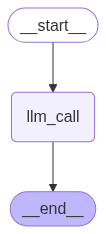

In [147]:
# Build State Graph
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END

build_graph=StateGraph(State)

build_graph.add_node("llm_call",llm_call)  
build_graph.add_edge(START,"llm_call")
build_graph.add_edge("llm_call",END)

graph=build_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [148]:
# invoke the graph
messages=graph.invoke({"messages":"What is 10 minus 2"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 10 minus 2
================================== Ai Message ==================================
Tool Calls:
  substract (7my5ykfqs)
 Call ID: 7my5ykfqs
  Args:
    a: 10
    b: 2


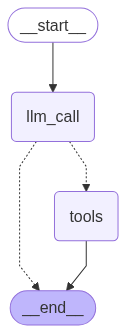

In [149]:
from langgraph.prebuilt import ToolNode,tools_condition

build_graph=StateGraph(State)
tool=[substract]

#add nodes
build_graph.add_node("llm_call",llm_call)  
build_graph.add_node("tools",ToolNode(tool))

#add edges
build_graph.add_edge(START,"llm_call")
build_graph.add_conditional_edges("llm_call",tools_condition)
build_graph.add_edge("tools",END)

graph=build_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [150]:
# invoke the graph
messages=graph.invoke({"messages":"What is 10 minus 2"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 10 minus 2
================================== Ai Message ==================================
Tool Calls:
  substract (kn9t55af2)
 Call ID: kn9t55af2
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: substract

8


In [151]:
# invoke the graph
messages=graph.invoke({"messages":"What is the capital of the world?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the capital of the world?
================================== Ai Message ==================================

There is no single capital of the world. The world is not a country with a unified government, so it does not have a single capital city. There are many international organizations and institutions with headquarters in cities like New York City, Geneva, and Brussels, but these are not the same as a country's capital.

If you're looking for information on a specific country or topic, I'd be happy to try and help you with that!
